In [1]:
# Display tools
from IPython.display import HTML, display  # For HTML rendering in notebooks
import os 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os

def get_dicom_paths(directory_path, label=None, verbose=True):
    """
    Scans a directory for DICOM (.dcm) files and returns their paths.

    Parameters:
    - directory_path (str): Directory to scan for .dcm files
    - label (str, optional): Label for display (e.g., 'train', 'test')
    - verbose (bool): Whether to print the number of files found

    Returns:
    - List[str]: Paths to DICOM files
    """
    dicom_paths = [
        os.path.join(directory_path, file)
        for file in os.listdir(directory_path)
        if file.lower().endswith('.dcm')
    ]
    
    if verbose:
        label_text = f" in the '{label}' directory" if label else ""
        print(f" Found {len(dicom_paths)} DICOM files{label_text}.")
    
    return dicom_paths

# --- Define Image Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"

# --- Get File Paths ---
train_img_path = get_dicom_paths(TRAIN_IMG_DIR, label="train")
test_img_path  = get_dicom_paths(TEST_IMG_DIR, label="test")


 Found 26684 DICOM files in the 'train' directory.
 Found 3000 DICOM files in the 'test' directory.


In [3]:
labels = pd.read_csv(r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
count_normal = len(labels.loc[labels['Target']==0])
count_pnemonia= len(labels.loc[labels['Target']==1])
traing_count=len(train_img_path)

In [5]:
weight_for_zero =(1/count_normal)*(traing_count)/2.0
weight_for_ones =(1/count_pnemonia)*(traing_count)/2.0

In [6]:
classweight= {0: weight_for_zero,
              1: weight_for_ones}

In [7]:
print("Weights:", classweight)

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


In [8]:
def parseMetadata(dcm):  # corrected from 'paraseMetadata'
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm:  # This forces conversion from lazy RawDataElement to DataElement
        pass

    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords


In [9]:
import pydicom
from tqdm import tqdm

In [10]:


# Step 1: Read DICOM files from paths
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path[:5000])]
test_dcms = [pydicom.dcmread(path) for path in tqdm(test_img_path[:5000])]




100%|██████████| 3000/3000 [01:31<00:00, 32.74it/s]


In [11]:
# Step 2: Parse metadata from DICOM datasets
trainMetaDicts, trainKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
testMetaDicts, testKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(test_dcms)])

100%|██████████| 3000/3000 [00:06<00:00, 439.84it/s]


In [12]:
def createY(df):
    """
    Returns binary labels: 1 if 'SeriesDescription' is 'view: PA', else 0.
    """
    if 'SeriesDescription' not in df.columns:
        raise ValueError("Missing 'SeriesDescription' column in DataFrame.")
    
    return (df['SeriesDescription'] == 'view: PA').astype(int).values


In [13]:
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

train_Y = createY(train_df)
test_Y = createY(test_df)


In [14]:
test_Y

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
def decodeImage(filePath):
    image = pydicom.dcmread(filePath).pixel_array
    image = cv2.resize(image, (64, 64))
    return image / 255.0


In [16]:

import cv2
import numpy as np

# Get our train x in the correct shape
train_X = []

for filePath in tqdm(train_img_path[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)

train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [01:44<00:00, 47.95it/s]


In [17]:
train_X_rgb

array([[[[0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.0745098 , 0.0745098 , 0.0745098 ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157]],

        ...,

        [[0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314]

In [18]:
test_X =[]
for filePath in tqdm(test_img_path[:5000]):
    
    img = decodeImage(filePath)
    test_X.append(img)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [01:22<00:00, 36.21it/s]


In [19]:
import matplotlib.pyplot as plt

def plot_score(hist):
    fig, ax = plt.subplots(5, 1, figsize=(10, 20))  # Corrected 'subplot' to 'subplots'
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title(f'Model {met}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()


In [20]:
!pip install tensorflow 

In [21]:
import tensorflow as tf

In [22]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model


In [23]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

In [24]:
import tensorflow as tf

# Clear, Flexible Exponential Decay Function
def exponential_decay(lr_initial, decay_steps, decay_rate=0.1):
    """
    Returns a function that computes exponentially decaying learning rate.
    
    Parameters:
    - lr_initial: Initial learning rate
    - decay_steps: Controls the rate of decay
    - decay_rate: The base of the exponential decay (default: 0.1)

    Returns:
    - A function that takes an epoch index and returns the decayed learning rate
    """
    def schedule(epoch):
        return lr_initial * decay_rate ** (epoch / decay_steps)
    return schedule

# Define the scheduler function
exponential_decay_fn = exponential_decay(lr_initial=0.01, decay_steps=20)

# Learning Rate Scheduler Callback
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn, verbose=1)

# Model Checkpoint Callback (saves best model only)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="xray_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Early Stopping Callback (restores best weights after patience period)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)


In [25]:
'''
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


'''

'\ndef exponential_decay(lr0, s):\n    def exponential_decay_fn(epoch):\n        return lr0 * 0.1 **(epoch / s)\n    return exponential_decay_fn\n\nexponential_decay_fn = exponential_decay(0.01, 20)\n\nlr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)\n\ncheckpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)\n\nearly_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)\n\n\n'

Baseline Model CNN

In [26]:
import tensorflow as tf

def build_fcnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [27]:
model_fcnn=build_fcnn_model()


c:\Users\samya\PyCharmProject\Pneumonia-Detection\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model_fcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,121 (6.00 MB)

 Trainable params: 1,573,121 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_fcnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [30]:
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format
history_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 100,
                          batch_size = 128,
                          validation_split = 0.15, 
                          class_weight = classweight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler_cb]) # Fit the model


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.5029 - accuracy: 0.5107 - loss: 30.6173 - precision: 0.5474 - recall: 0.6677
Epoch 1: val_loss improved from inf to 1.55926, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - AUC: 0.5060 - accuracy: 0.5133 - loss: 29.7570 - precision: 0.5489 - recall: 0.6702 - val_AUC: 0.8514 - val_accuracy: 0.5867 - val_loss: 1.5593 - val_precision: 0.5674 - val_recall: 0.9951 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.8564 - accuracy: 0.7419 - loss: 0.5803 - precision: 0.7167 - recall: 0.8767
Epoch 2: val_loss improved from 1.55926 to 0.33099, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - AUC: 0.8572 - accuracy: 0.7432 - loss: 0.5769 - precision: 0.7179 - recall: 0.8773 - val_AUC: 0.9315 - val_accuracy: 0.8520 - val_loss: 0.3310 - val_precision: 0.8520 - val_recall: 0.8793 - learning_rate: 0.0089

Epoch 3: LearningRateScheduler setting learning rate to 0.007943282347242816.
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.9315 - accuracy: 0.8416 - loss: 0.3159 - precision: 0.8200 - recall: 0.9172
Epoch 3: val_loss did not improve from 0.33099
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - AUC: 0.9315 - accuracy: 0.8417 - loss: 0.3157 - precision: 0.8199 - recall: 0.9174 - val_AUC: 0.9518 - val_accuracy: 0.6800 - val_loss: 0.6852 - val_precision: 0.6293 - val_recall: 0.9951 - learning_rate: 0.0079

Epoch 4: LearningRateScheduler setting learning rate to 0.0070794578438413795.
Epoch 4/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - AUC: 0.9289 - accuracy: 0.8162 - loss: 0.3296 - precision: 0.7765 - recall: 0.9261
Epoch 4: val

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.9466 - accuracy: 0.8443 - loss: 0.2844 - precision: 0.8083 - recall: 0.9392 - val_AUC: 0.9607 - val_accuracy: 0.8853 - val_loss: 0.2565 - val_precision: 0.9020 - val_recall: 0.8842 - learning_rate: 0.0050

Epoch 8: LearningRateScheduler setting learning rate to 0.004466835921509631.
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.9524 - accuracy: 0.8739 - loss: 0.2727 - precision: 0.8568 - recall: 0.9178
Epoch 8: val_loss did not improve from 0.25647
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - AUC: 0.9526 - accuracy: 0.8741 - loss: 0.2721 - precision: 0.8568 - recall: 0.9184 - val_AUC: 0.9651 - val_accuracy: 0.8280 - val_loss: 0.3820 - val_precision: 0.7669 - val_recall: 0.9803 - learning_rate: 0.0045

Epoch 9: LearningRateScheduler setting learning rate to 0.0039810717055349725.
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.9594 - accuracy: 0.8702 - loss: 0.2510 - precision: 0.8316 - recall: 0.9540
Epoch 9: val

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - AUC: 0.9593 - accuracy: 0.8703 - loss: 0.2509 - precision: 0.8320 - recall: 0.9537 - val_AUC: 0.9639 - val_accuracy: 0.8947 - val_loss: 0.2513 - val_precision: 0.8884 - val_recall: 0.9212 - learning_rate: 0.0040

Epoch 10: LearningRateScheduler setting learning rate to 0.003548133892335755.
Epoch 10/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - AUC: 0.9622 - accuracy: 0.8874 - loss: 0.2378 - precision: 0.8629 - recall: 0.9437
Epoch 10: val_loss did not improve from 0.25130
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - AUC: 0.9623 - accuracy: 0.8873 - loss: 0.2378 - precision: 0.8626 - recall: 0.9440 - val_AUC: 0.9666 - val_accuracy: 0.8800 - val_loss: 0.2736 - val_precision: 0.8420 - val_recall: 0.9581 - learning_rate: 0.0035

Epoch 11: LearningRateScheduler setting learning rate to 0.0031622776601683794.
Epoch 11/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.9661 - accuracy: 0.8854 - loss: 0.2298 - precision: 0.8584 - recall: 0.9482
Epoch 1

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - AUC: 0.9722 - accuracy: 0.9019 - loss: 0.2080 - precision: 0.8775 - recall: 0.9540 - val_AUC: 0.9664 - val_accuracy: 0.8960 - val_loss: 0.2432 - val_precision: 0.8923 - val_recall: 0.9187 - learning_rate: 0.0028

Epoch 13: LearningRateScheduler setting learning rate to 0.0025118864315095803.
Epoch 13/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - AUC: 0.9626 - accuracy: 0.8899 - loss: 0.2374 - precision: 0.8649 - recall: 0.9394
Epoch 13: val_loss did not improve from 0.24315
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - AUC: 0.9627 - accuracy: 0.8897 - loss: 0.2373 - precision: 0.8647 - recall: 0.9397 - val_AUC: 0.9675 - val_accuracy: 0.8933 - val_loss: 0.2528 - val_precision: 0.8688 - val_recall: 0.9458 - learning_rate: 0.0025

Epoch 14: LearningRateScheduler setting learning rate to 0.0022387211385683395.
Epoch 14/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - AUC: 0.9676 - accuracy: 0.8854 - loss: 0.2228 - precision: 0.8520 - recall: 0.9508
Epoch 

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - AUC: 0.9646 - accuracy: 0.8880 - loss: 0.2299 - precision: 0.8566 - recall: 0.9535 - val_AUC: 0.9680 - val_accuracy: 0.9040 - val_loss: 0.2338 - val_precision: 0.9175 - val_recall: 0.9039 - learning_rate: 0.0016

Epoch 18: LearningRateScheduler setting learning rate to 0.0014125375446227546.
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.9665 - accuracy: 0.8865 - loss: 0.2254 - precision: 0.8690 - recall: 0.9405
Epoch 18: val_loss did not improve from 0.23384
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - AUC: 0.9665 - accuracy: 0.8866 - loss: 0.2253 - precision: 0.8689 - recall: 0.9406 - val_AUC: 0.9698 - val_accuracy: 0.8947 - val_loss: 0.2484 - val_precision: 0.8674 - val_recall: 0.9507 - learning_rate: 0.0014

Epoch 19: LearningRateScheduler setting learning rate to 0.0012589254117941673.
Epoch 19/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.9695 - accuracy: 0.8954 - loss: 0.2151 - precision: 0.8725 - recall: 0.9476
Epoch 

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - AUC: 0.9655 - accuracy: 0.8854 - loss: 0.2296 - precision: 0.8546 - recall: 0.9515 - val_AUC: 0.9700 - val_accuracy: 0.9093 - val_loss: 0.2314 - val_precision: 0.9043 - val_recall: 0.9310 - learning_rate: 8.9125e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0007943282347242814.
Epoch 23/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.9728 - accuracy: 0.9024 - loss: 0.2070 - precision: 0.8756 - recall: 0.9550
Epoch 23: val_loss did not improve from 0.23141
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - AUC: 0.9727 - accuracy: 0.9023 - loss: 0.2072 - precision: 0.8755 - recall: 0.9549 - val_AUC: 0.9718 - val_accuracy: 0.8747 - val_loss: 0.2832 - val_precision: 0.8250 - val_recall: 0.9754 - learning_rate: 7.9433e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0007079457843841381.
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.9677 - accuracy: 0.8900 - loss: 0.2209 - precision: 0.8605 - recall: 0.947

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - AUC: 0.9678 - accuracy: 0.8903 - loss: 0.2206 - precision: 0.8609 - recall: 0.9472 - val_AUC: 0.9707 - val_accuracy: 0.9080 - val_loss: 0.2302 - val_precision: 0.9021 - val_recall: 0.9310 - learning_rate: 7.0795e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0006309573444801933.
Epoch 25/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - AUC: 0.9711 - accuracy: 0.9030 - loss: 0.2093 - precision: 0.8836 - recall: 0.9471
Epoch 25: val_loss did not improve from 0.23016
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - AUC: 0.9711 - accuracy: 0.9032 - loss: 0.2092 - precision: 0.8835 - recall: 0.9474 - val_AUC: 0.9715 - val_accuracy: 0.9040 - val_loss: 0.2432 - val_precision: 0.8795 - val_recall: 0.9532 - learning_rate: 6.3096e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0005623413251903491.
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.9705 - accuracy: 0.9035 - loss: 0.2115 - precision: 0.8801 - recall: 0.949

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9650 - accuracy: 0.8967 - loss: 0.2496 - precision: 0.8853 - recall: 0.9256
{'loss': 0.24838389456272125, 'compile_metrics': 0.9020000100135803}


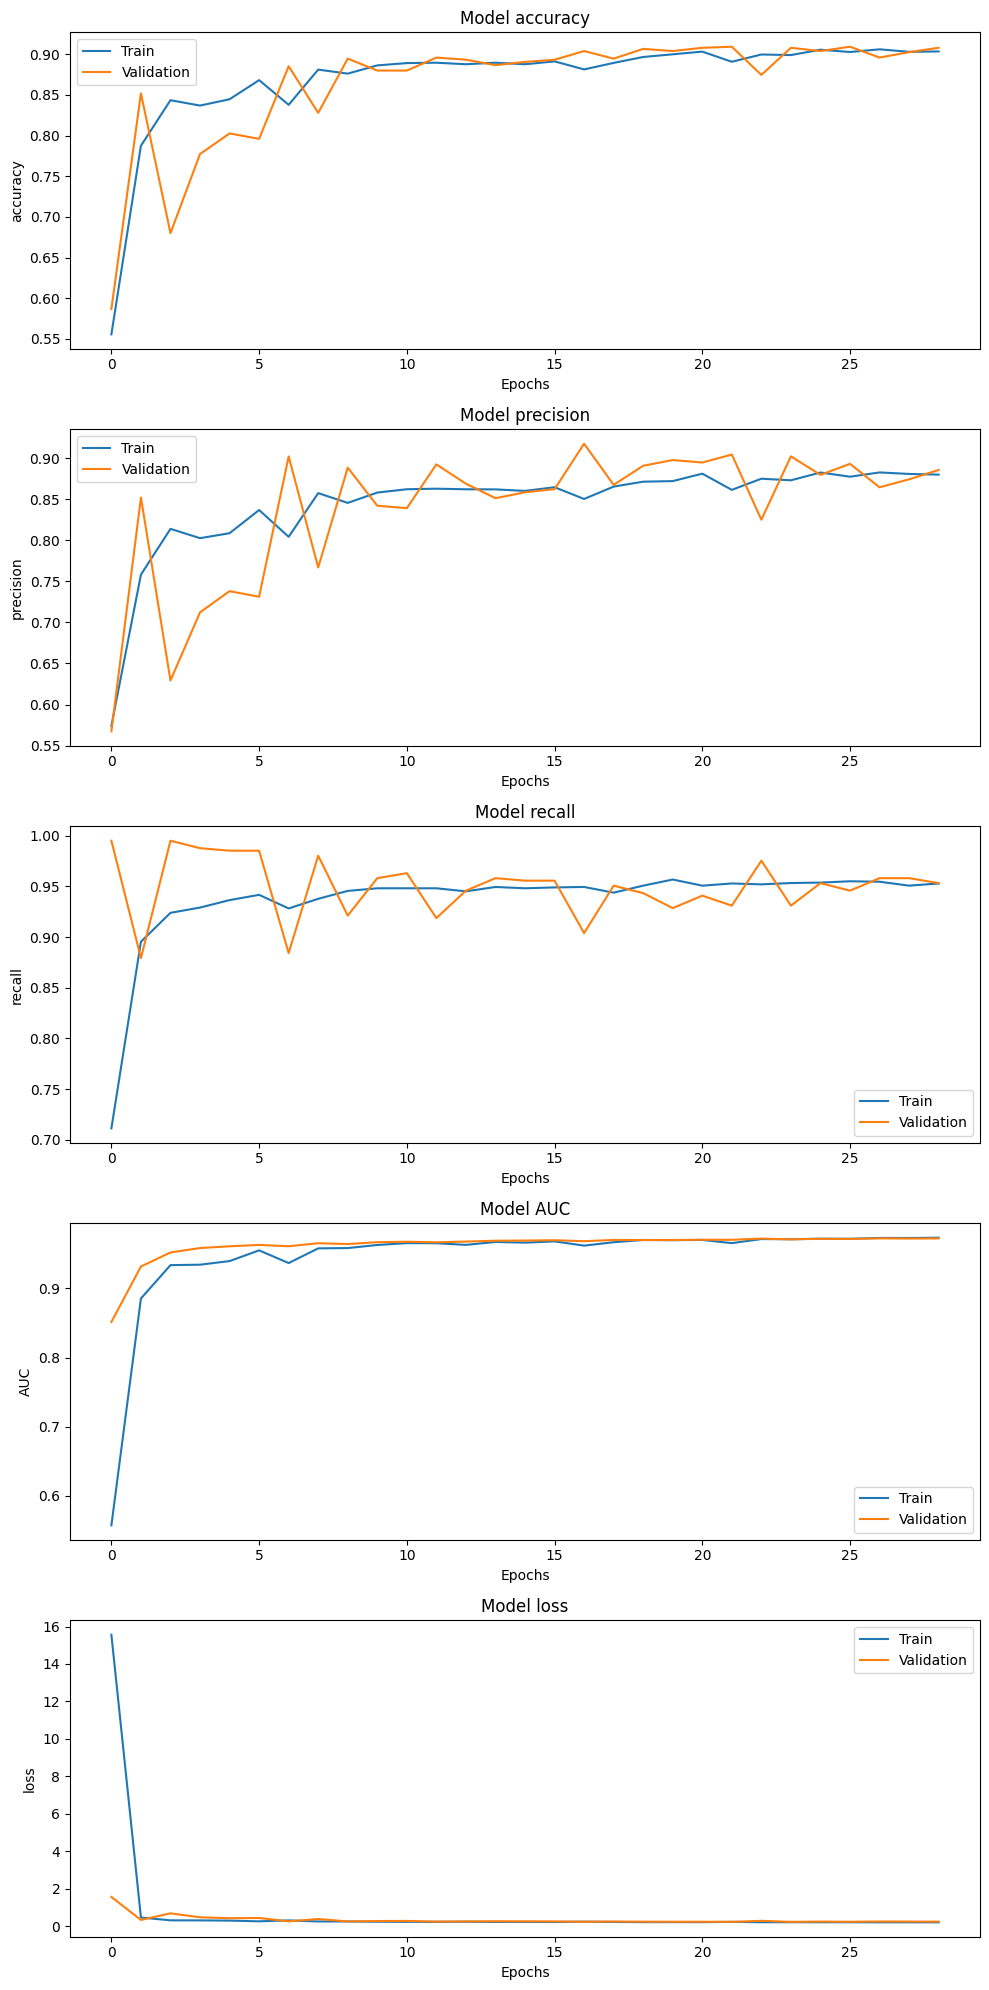

In [31]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plot_score(history_fcnn) # Visualise scores

In [32]:
'''
import tensorflow as tf

def Cust_Cnn_model1():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model
    '''


"\nimport tensorflow as tf\n\ndef Cust_Cnn_model1():\n    model = tf.keras.Sequential([\n        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n\n        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n\n        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n        tf.keras.layers.Dropout(0.4),\n\n        tf.keras.layers.Flatten(),\n        tf.keras.layers.Dense(256, activation='relu'),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.Dropout(0.5),\n\n        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification\n    ])\n    return model\n    "

In [33]:
def Cust_Cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu', input_shape=(64, 64, 3)), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu'), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(), # flatten output of conv
        tf.keras.layers.Dense(512, activation = "relu"), # hidden layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation = "relu"), #  output layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")])
    
    return model

In [34]:

# Instantiate the model
model_cnn = Cust_Cnn_model()


c:\Users\samya\PyCharmProject\Pneumonia-Detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:

# Print model summary
model_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,810,273 (6.91 MB)

 Trainable params: 1,808,737 (6.90 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [36]:

# Compile the model
model_cnn.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


In [37]:
# Fit model
history_cnn = model_cnn.fit(train_X_rgb, 
                      train_Y,  
                      epochs=50, 
                      validation_split = 0.15, 
                      batch_size=128,
                      class_weight=classweight,
                      callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb],
                      verbose=1) # Fit the model


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - AUC: 0.9156 - accuracy: 0.7158 - loss: 0.7008 - precision: 0.8332 - recall: 0.8826
Epoch 1: val_loss did not improve from 0.23016
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - AUC: 0.9157 - accuracy: 0.7182 - loss: 0.6941 - precision: 0.8332 - recall: 0.8828 - val_AUC: 0.5000 - val_accuracy: 0.5413 - val_loss: 89.5514 - val_precision: 0.5413 - val_recall: 1.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - AUC: 0.9580 - accuracy: 0.8841 - loss: 0.2435 - precision: 0.8656 - recall: 0.9343
Epoch 2: val_loss did not improve from 0.23016
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 709ms/step - AUC: 0.9581 - accuracy: 0.8845 - loss: 0.2431 - precision: 0.8658 - recall: 0.9347 - val_AUC: 0.5189 - val_accuracy: 0.5453 - val_loss: 6.1143 - val_precision: 0.5440 - val_recall: 0.9901 -

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - AUC: 0.9692 - accuracy: 0.8968 - loss: 0.2600 - precision: 0.8627 - recall: 0.9582
Test Results: {'loss': 0.2602272927761078, 'compile_metrics': 0.8939999938011169}


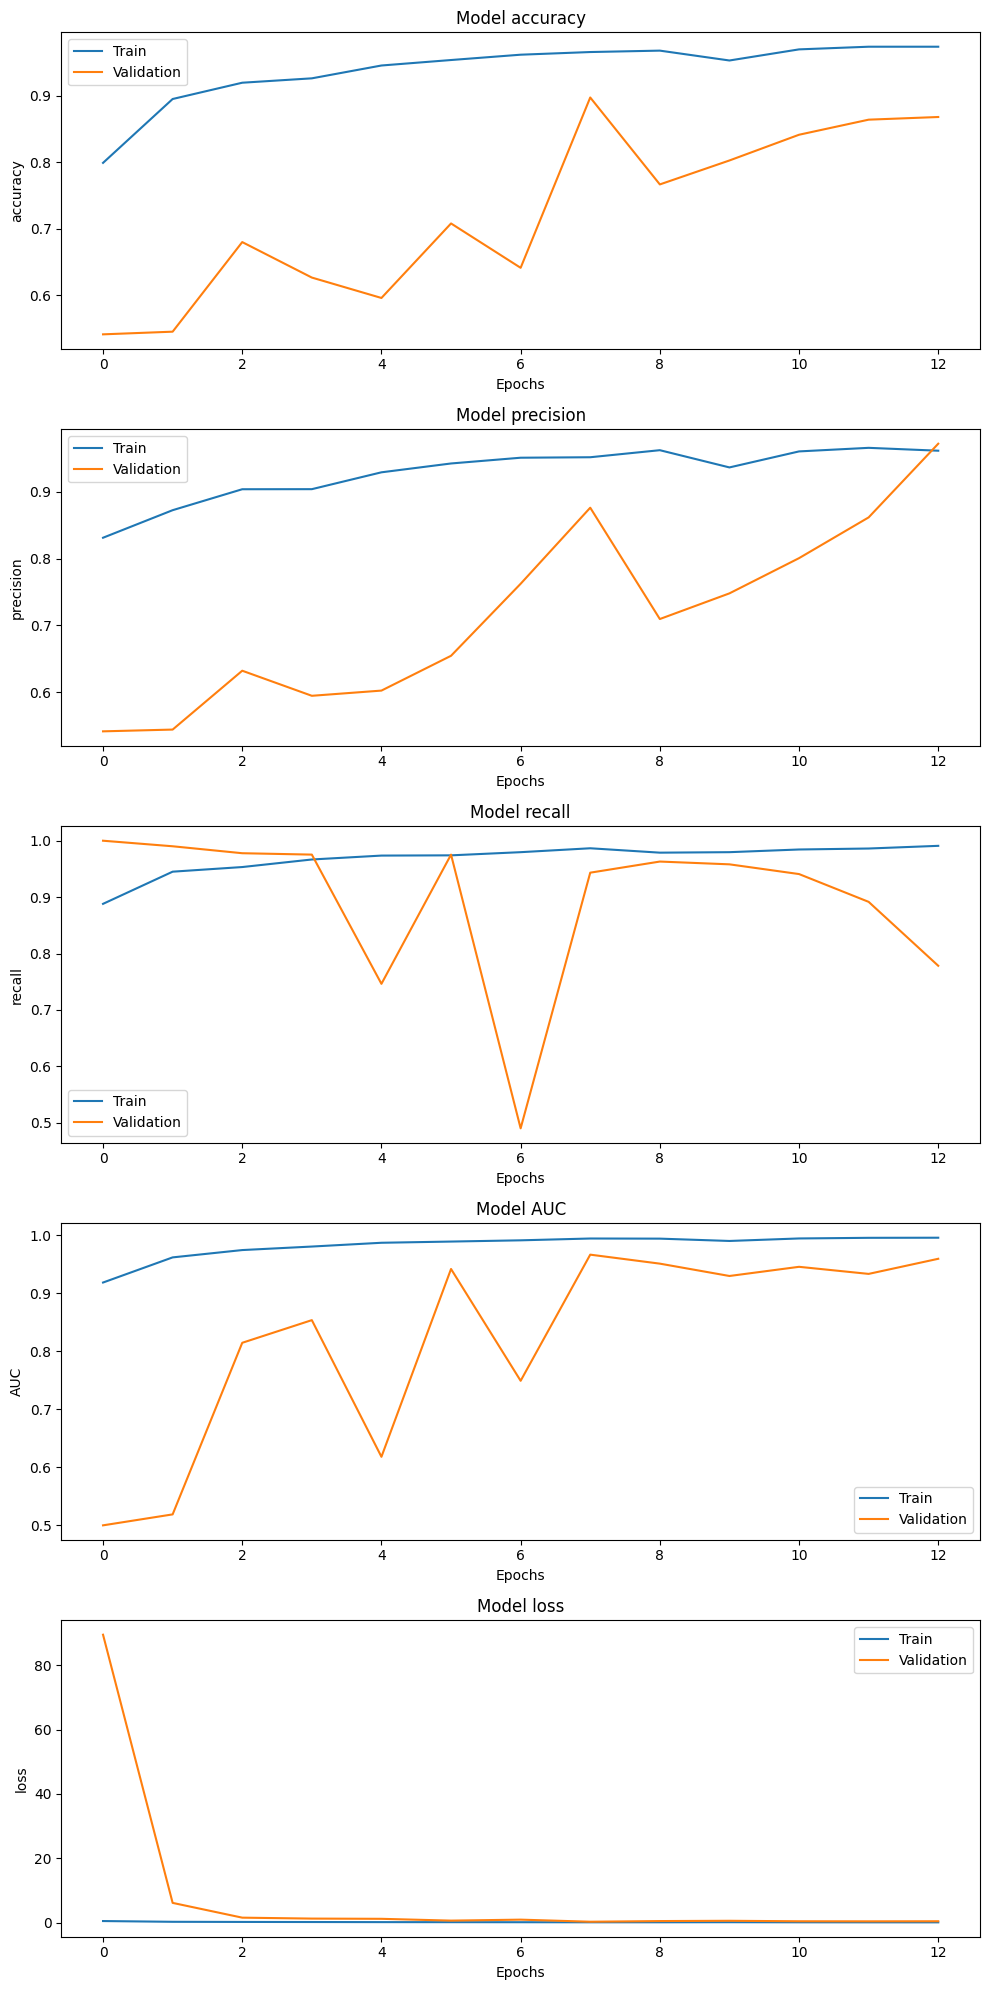

In [38]:
# Evaluate the trained model on test data
results = model_cnn.evaluate(test_X_rgb, test_Y, verbose=1)

# Convert results to a dictionary for readability
results_dict = dict(zip(model_cnn.metrics_names, results))
print("Test Results:", results_dict)

# Visualize training history
plot_score(history_cnn)


In [39]:
model = Cust_Cnn_model()

In [40]:
def build_mn_model():
    model= tf.keras.Sequential([
        tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(64, 64, 3)),
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(1, activation = 'sigmoid')
    ])
    model.layers[0].trainable = False
    return model


In [41]:
# Build and compile mobile net model
model_mn = build_mn_model()
model_mn.summary()
model_mn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

C:\Users\samya\AppData\Local\Temp\ipykernel_14736\1279185705.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(64, 64, 3)),


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
history_mn = model_mn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 100, 
                          validation_split = 0.15, 
                          class_weight = classweight,
                          batch_size = 128,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler_cb]
                          )


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - AUC: 0.9418 - accuracy: 0.7518 - loss: 0.4640 - precision: 0.8216 - recall: 0.9397
Epoch 1: val_loss improved from 0.23016 to 0.19959, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 750ms/step - AUC: 0.9420 - accuracy: 0.7547 - loss: 0.4593 - precision: 0.8220 - recall: 0.9398 - val_AUC: 0.9773 - val_accuracy: 0.9240 - val_loss: 0.1996 - val_precision: 0.9125 - val_recall: 0.9507 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - AUC: 0.9839 - accuracy: 0.9392 - loss: 0.1496 - precision: 0.9237 - recall: 0.9713
Epoch 2: val_loss improved from 0.19959 to 0.16897, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 398ms/step - AUC: 0.9840 - accuracy: 0.9392 - loss: 0.1492 - precision: 0.9238 - recall: 0.9713 - val_AUC: 0.9842 - val_accuracy: 0.9347 - val_loss: 0.1690 - val_precision: 0.9200 - val_recall: 0.9631 - learning_rate: 0.0089

Epoch 3: LearningRateScheduler setting learning rate to 0.007943282347242816.
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - AUC: 0.9931 - accuracy: 0.9554 - loss: 0.1028 - precision: 0.9448 - recall: 0.9761
Epoch 3: val_loss did not improve from 0.16897
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - AUC: 0.9930 - accuracy: 0.9554 - loss: 0.1030 - precision: 0.9447 - recall: 0.9762 - val_AUC: 0.9841 - val_accuracy: 0.9320 - val_loss: 0.1802 - val_precision: 0.9062 - val_recall: 0.9754 - learning_rate: 0.0079

Epoch 4: LearningRateScheduler setting learning rate to 0.0070794578438413795.
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - AUC: 0.9947 - accuracy: 0.9675 - loss: 0.0872 - precision: 0.9530 - recall: 0.9896
Epoch 

34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - AUC: 0.9947 - accuracy: 0.9674 - loss: 0.0873 - precision: 0.9529 - recall: 0.9896 - val_AUC: 0.9859 - val_accuracy: 0.9360 - val_loss: 0.1642 - val_precision: 0.9144 - val_recall: 0.9729 - learning_rate: 0.0071

Epoch 5: LearningRateScheduler setting learning rate to 0.006309573444801933.
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - AUC: 0.9971 - accuracy: 0.9773 - loss: 0.0712 - precision: 0.9657 - recall: 0.9936
Epoch 5: val_loss improved from 0.16424 to 0.14549, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step - AUC: 0.9971 - accuracy: 0.9771 - loss: 0.0714 - precision: 0.9655 - recall: 0.9936 - val_AUC: 0.9883 - val_accuracy: 0.9400 - val_loss: 0.1455 - val_precision: 0.9227 - val_recall: 0.9704 - learning_rate: 0.0063

Epoch 6: LearningRateScheduler setting learning rate to 0.005623413251903491.
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - AUC: 0.9971 - accuracy: 0.9763 - loss: 0.0704 - precision: 0.9645 - recall: 0.9932
Epoch 6: val_loss did not improve from 0.14549
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 518ms/step - AUC: 0.9971 - accuracy: 0.9762 - loss: 0.0705 - precision: 0.9645 - recall: 0.9932 - val_AUC: 0.9883 - val_accuracy: 0.9387 - val_loss: 0.1529 - val_precision: 0.9186 - val_recall: 0.9729 - learning_rate: 0.0056

Epoch 7: LearningRateScheduler setting learning rate to 0.005011872336272724.
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - AUC: 0.9973 - accuracy: 0.9773 - loss: 0.0688 - precision: 0.9671 - recall: 0.9924
Epoch 7

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 489ms/step - AUC: 0.9973 - accuracy: 0.9773 - loss: 0.0688 - precision: 0.9671 - recall: 0.9925 - val_AUC: 0.9887 - val_accuracy: 0.9427 - val_loss: 0.1427 - val_precision: 0.9271 - val_recall: 0.9704 - learning_rate: 0.0050

Epoch 8: LearningRateScheduler setting learning rate to 0.004466835921509631.
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - AUC: 0.9981 - accuracy: 0.9824 - loss: 0.0610 - precision: 0.9748 - recall: 0.9934
Epoch 8: val_loss did not improve from 0.14273
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 409ms/step - AUC: 0.9981 - accuracy: 0.9824 - loss: 0.0610 - precision: 0.9747 - recall: 0.9934 - val_AUC: 0.9886 - val_accuracy: 0.9387 - val_loss: 0.1494 - val_precision: 0.9186 - val_recall: 0.9729 - learning_rate: 0.0045

Epoch 9: LearningRateScheduler setting learning rate to 0.0039810717055349725.
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - AUC: 0.9988 - accuracy: 0.9823 - loss: 0.0552 - precision: 0.9721 - recall: 0.9961
Epoch 

34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - AUC: 0.9988 - accuracy: 0.9823 - loss: 0.0553 - precision: 0.9720 - recall: 0.9961 - val_AUC: 0.9895 - val_accuracy: 0.9453 - val_loss: 0.1371 - val_precision: 0.9314 - val_recall: 0.9704 - learning_rate: 0.0040

Epoch 10: LearningRateScheduler setting learning rate to 0.003548133892335755.
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - AUC: 0.9985 - accuracy: 0.9796 - loss: 0.0573 - precision: 0.9672 - recall: 0.9966
Epoch 10: val_loss did not improve from 0.13712
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - AUC: 0.9985 - accuracy: 0.9797 - loss: 0.0573 - precision: 0.9673 - recall: 0.9966 - val_AUC: 0.9894 - val_accuracy: 0.9387 - val_loss: 0.1450 - val_precision: 0.9167 - val_recall: 0.9754 - learning_rate: 0.0035

Epoch 11: LearningRateScheduler setting learning rate to 0.0031622776601683794.
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - AUC: 0.9984 - accuracy: 0.9845 - loss: 0.0509 - precision: 0.9769 - recall: 0.9955
E

34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - AUC: 0.9992 - accuracy: 0.9865 - loss: 0.0466 - precision: 0.9774 - recall: 0.9978 - val_AUC: 0.9899 - val_accuracy: 0.9453 - val_loss: 0.1356 - val_precision: 0.9335 - val_recall: 0.9680 - learning_rate: 0.0025

Epoch 14: LearningRateScheduler setting learning rate to 0.0022387211385683395.
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - AUC: 0.9990 - accuracy: 0.9873 - loss: 0.0459 - precision: 0.9787 - recall: 0.9981
Epoch 14: val_loss did not improve from 0.13563
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 727ms/step - AUC: 0.9990 - accuracy: 0.9873 - loss: 0.0460 - precision: 0.9787 - recall: 0.9981 - val_AUC: 0.9898 - val_accuracy: 0.9440 - val_loss: 0.1374 - val_precision: 0.9292 - val_recall: 0.9704 - learning_rate: 0.0022

Epoch 15: LearningRateScheduler setting learning rate to 0.0019952623149688802.
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - AUC: 0.9982 - accuracy: 0.9870 - loss: 0.0498 - precision: 0.9793 - recall: 0.9972


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - AUC: 0.9866 - accuracy: 0.9389 - loss: 0.1544 - precision: 0.9269 - recall: 0.9608
{'loss': 0.14732612669467926, 'compile_metrics': 0.9440000057220459}


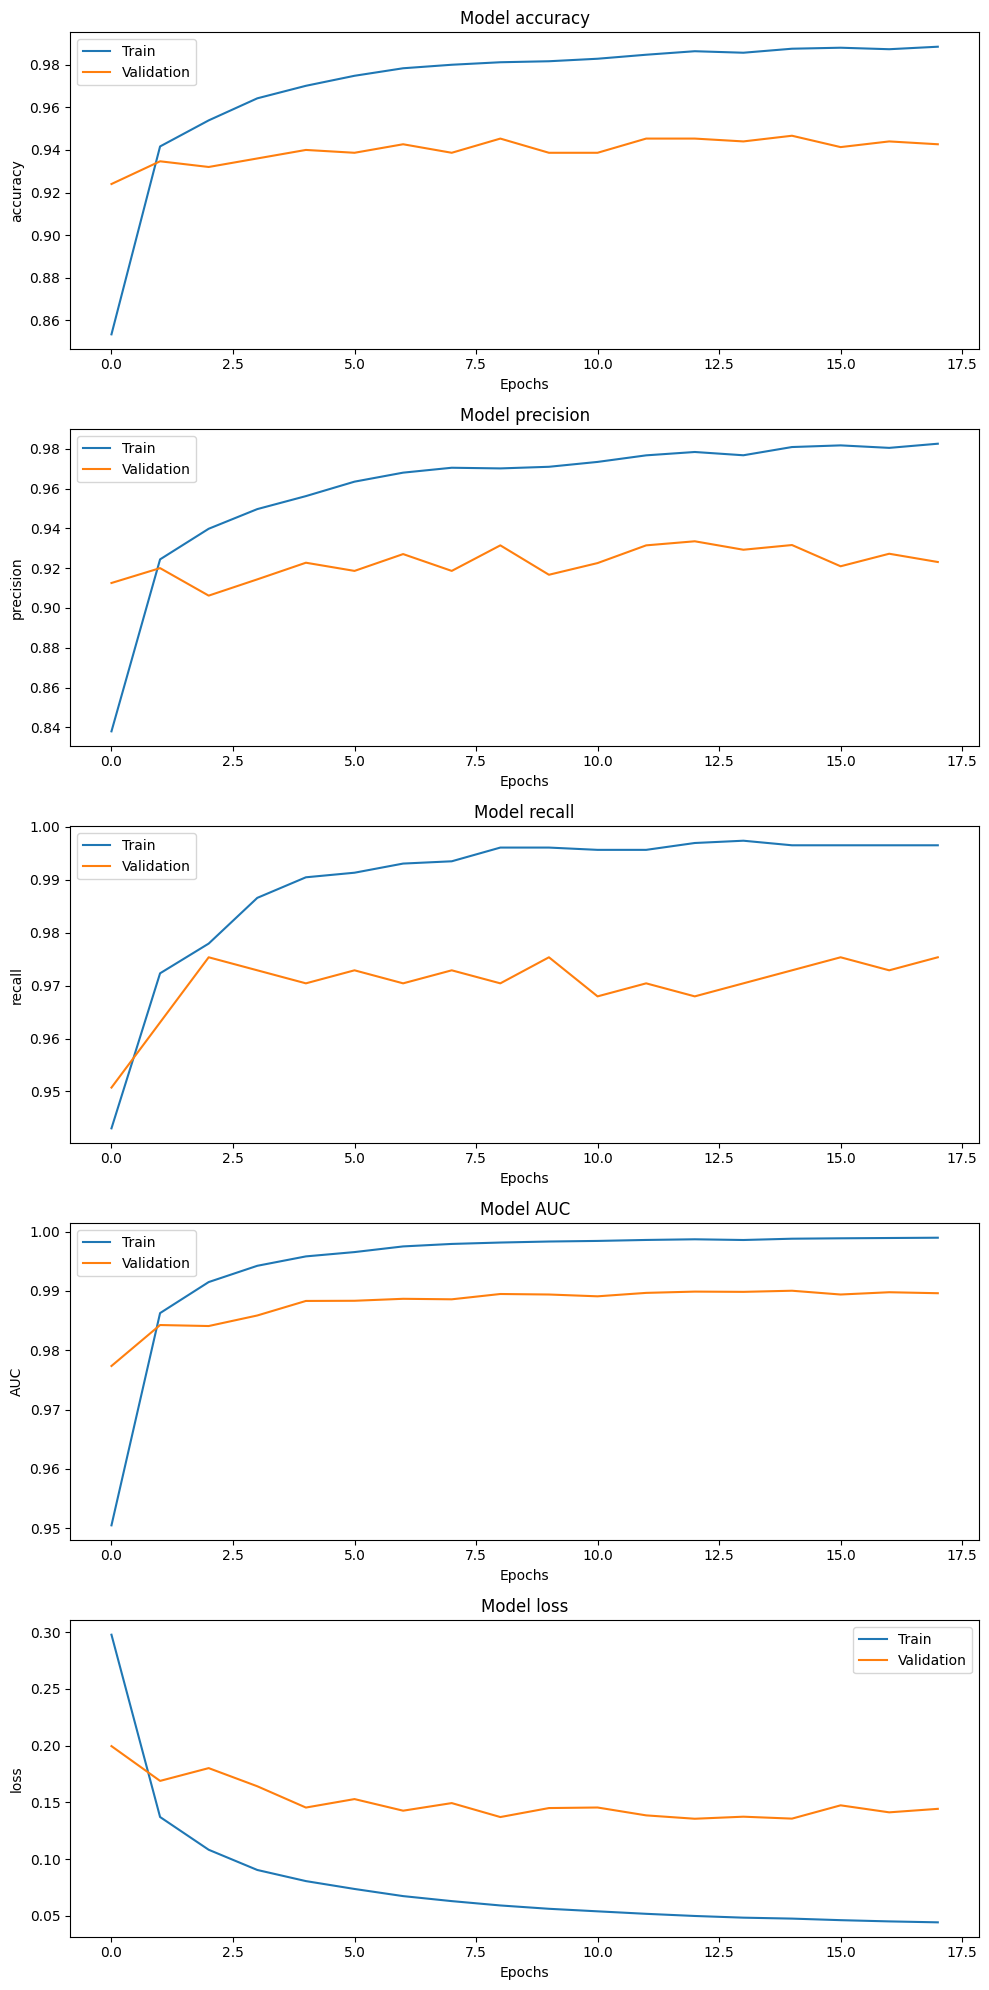

In [43]:
# Show results and print graphs
results = model_mn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_mn.metrics_names,results))

print(results)
plot_score(history_mn) # Visualise scores

A/B Testing 


In [ ]:
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path)]
trainMetaDicts, _ = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
train_Y = createY(train_df)


 26%|██▋       | 7067/26684 [00:05<00:16, 1215.08it/s]

In [ ]:
import numpy as np
import random
import pydicom
import cv2
import tensorflow as tf

# Select a random index beyond the first 5000
random_index = random.choice(range(5000, len(train_img_path)))
#random_index = random.choice(range(0, 5000))

# Get the image path and true label
image_path = train_img_path[random_index]
true_label = train_Y[random_index]

# Load and preprocess the DICOM image
def load_and_preprocess_dicom(path):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array.astype(np.float32)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_rgb = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    return np.expand_dims(img_rgb, axis=0)  # Add batch dimension

# Prepare image
input_image = load_and_preprocess_dicom(image_path)

# Predict using the trained model
prediction = model_cnn.predict(input_image)[0][0]
predicted_label = int(prediction >= 0.5)

# Output results
print(f"Random image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted probability: {prediction:.4f}")
print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Random image path: C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images\ea696000-e0e3-495e-82e1-e0b5ea273cb7.dcm
True label: 1
Predicted probability: 0.3679
Predicted label: 0


In [ ]:
import numpy as np
import random
import pydicom
import cv2
import tensorflow as tf

# Select a random index beyond the first 5000
random_index = random.choice(range(5000, len(train_img_path)))
#random_index = random.choice(range(0, 5000))

# Get the image path and true label
image_path = train_img_path[random_index]
true_label = train_Y[random_index]

# Load and preprocess the DICOM image
def load_and_preprocess_dicom(path):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array.astype(np.float32)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_rgb = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    return np.expand_dims(img_rgb, axis=0)  # Add batch dimension

# Prepare image
input_image = load_and_preprocess_dicom(image_path)

# Predict using the trained model
prediction = model_fcnn.predict(input_image)[0][0]
predicted_label = int(prediction >= 0.5)

# Output results
print(f"Random image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted probability: {prediction:.4f}")
print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Random image path: C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images\85eebfe1-8819-408e-a5a0-6df1d4165e9a.dcm
True label: 0
Predicted probability: 0.0788
Predicted label: 0
